In [68]:
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from bs4 import BeautifulSoup

import requests
import matplotlib.pyplot as plt
import numpy
import pandas as pd  
from math import *
import time, datetime
import sys
sys.version

'3.7.5 (default, Oct 31 2019, 15:18:51) [MSC v.1916 64 bit (AMD64)]'

In [69]:
now = str(time.time()).split('.')[0]
print(now)
print(str(datetime.datetime.now()).split('.')[0])

1577755652
2019-12-30 20:27:32


In [71]:
bidsAreHigh = False
maPortfolio = 25000
maCash = 25000

url = "https://query1.finance.yahoo.com/v8/finance/chart/%5EGSPC?symbol=%5EGSPC&period1={}&period2={}&interval={}&includePrePost=true&events=div%7Csplit%7Cearn&lang=en-US&region=US&crumb=ED2zlWJHcMa&corsDomain=finance.yahoo.com"

r = requests.get(url.format('1574186393', now, '30m'))

# r = requests.get("""https://query1.finance.yahoo.com/v8/finance/chart/%5EGSPC?symbol=%5EGSPC&period1=1574186393&period2=1576778393&interval=30m&includePrePost=true&events=div%7Csplit%7Cearn&lang=en-US&region=US&crumb=ED2zlWJHcMa&corsDomain=finance.yahoo.com
# """)
yahoo = r.json()
time = yahoo["chart"]["result"][0]["timestamp"]
quote = yahoo["chart"]["result"][0]["indicators"]["quote"][0]



In [74]:
def ROC(df, n, price='Close'):
    """
    Rate of Change
    """
    M = df[price].diff(n - 1)
    N = df[price].shift(n - 1)
    result = pd.Series(M / N, name='ROC_' + str(n))
    return result

def MFI2(df, n):
    """
    Money Flow Index and Ratio
    """
    PP = (df['High'] + df['Low'] + df['Close']) / 3
    i = 0
    PosMF = [0]
    while i < len(df) - 1:  # df.index[-1]:
        if PP[i + 1] > PP[i]:
            PosMF.append(PP[i + 1] * df.iat[i + 1, df.columns.get_loc('Volume')])
        else:
            PosMF.append(0)
        i=i + 1
    PosMF = pd.Series(PosMF)
    TotMF = PP * df['Volume']
    MFR = pd.Series(PosMF / TotMF)
    result = pd.Series(MFR.rolling(n).mean(), name='MFI_' + str(n))
    return result


# intialise data of lists. 
data = {'Open': quote['open'] , 
        'Low': quote['low'] , 
        'High': quote['high'], 
        'Close': quote['close'],
        'Volume': quote['volume']} 
  
# Create DataFrame 
df = pd.DataFrame(data) 
  
# Print the output. 
df 

,Open,Low,High,Close,Volume
0,3119.360107,3119.290039,3120.560059,3120.560059,0
1,3120.570068,3118.729980,3122.389893,3121.030029,76558773
2,3121.030029,3120.699951,3122.659912,3121.040039,78143695
3,3121.030029,3121.030029,3125.159912,3124.820068,84908468
4,3124.820068,3121.570068,3124.860107,3122.040039,83130457
...,...,...,...,...,...
397,3223.080078,3221.669922,3223.239990,3222.040039,54345199
398,3222.040039,3221.189941,3224.649902,3224.120117,67627685
399,3224.129883,3217.899902,3224.550049,3221.540039,181849786
400,3221.530000,3221.290000,3221.540000,3221.290000,1356475578


In [ ]:
# mf = MFI(df, 14)
mfi = MFI2(df, 14)
mfi.plot(figsize=(16, 5))
# mf
print(mfi)

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
yo
y

KeyboardInterrupt: 

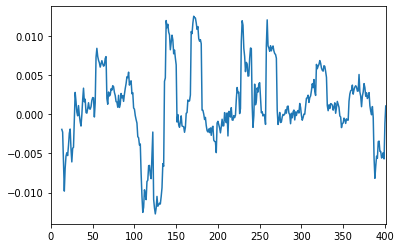

In [100]:
roc = ROC(df ,14)
roc.plot()

import threading
def threaded(fn):
    def wrapper(*args, **kwargs):
        threading.Thread(target=fn, args=args, kwargs=kwargs).start()
    return wrapper

class MyClass:
#     somevar = 'someval'
    def __init__(self):
       self.somevar = 'someval'
       t1 = threading.Thread(target=self.func_to_be_threaded())
       t2 = threading.Thread(target=self.loop())
       t2.start()
       t1.start()


    def func_to_be_threaded(self):
        while self.somevar == 'someval':
            print('yo')
            

    def loop(self):
        for i in 100:
           print(i)
           if i == 30:
              self.somevar = 'drrr'
            
    
MyClass().__init__()

In [2]:
def buy(stockPrice, n):
#     getAmount
#     subtract
#     keep the amount as a sum of stock value and the remaining cash
    stocksValue = stockPrice * n
    maCash = maCash - stocksValue
    
book = None
bookSoup = None
browser = webdriver.Chrome('C:\chromedriver')
bookRaw = None

def startBrowser():
    global book
    global bookSoup
    global browser
    global bookRaw
    browser.get('http://markets.cboe.com/us/equities/market_statistics/book_viewer/')
    time.sleep(2)
    EDGX = browser.find_element_by_xpath('//span[text()="EDGX Equities"]')
    actions = ActionChains(browser)
    actions.pause(1)
    print(EDGX)
    actions.click(EDGX)
    actions.pause(1)
    actions.perform()
    bookRaw = browser.find_element_by_xpath('//*[@id="bookViewer0"]/div[1]/table[2]/tbody')
    price = browser.find_element_by_class_name('book-viewer__trades-price').text
#     shares = 
    book = bookRaw.get_attribute('innerHTML')
    bookSoup = BeautifulSoup(book, 'lxml').html.body
    i = 0
#     for row in bookSoup:
#         i+=1
#         print('row number %s printing' % i)
#         for subrow in row:
#             print(subrow)
    print(price)
    print('book ===============>', book)
    print('bookSoup ===============>', bookSoup)
    
    
startBrowser()

<selenium.webdriver.remote.webelement.WebElement (session="8c38baa765c95c672cdaf1335c15467a", element="29c93eb0-81f6-4394-8ee3-5c77c19fdf12")>
322.42
book ===============> 
              <tr class="book-viewer-data-row">
                  <td class="book-viewer__ask__th t5" rowspan="5" style="display: table-cell;"><i class="sprite book-viewer__sprite book-viewer__sprite--ask"></i><span class="hide">Asks</span></td>
                  <td class="book-viewer__ask book-viewer__ask-shares" id="ext-gen1052" style="display: table-cell;">3,772</td>
                  <td class="book-viewer__ask book-viewer__ask-quotes" id="ext-gen1054" style="display: none;">&nbsp;</td>
                  <td class="book-viewer__ask book-viewer__ask-price book-viewer-price" id="ext-gen1053" style="display: table-cell;">322.54</td>
                  <td class="book-viewer__trades-time" id="ext-gen1084" style="display: table-cell;">18:34:37</td>
                  <td class="book-viewer__trades-price" id="ext-gen10

In [ ]:
i = 0
attachment = []
last10Trades = browser.find_elements_by_class_name("book-viewer__trades-price")
topBidsPrice = browser.find_elements_by_class_name("book-viewer__bid-price")
topBidShares = browser.find_elements_by_class_name("book-viewer__bid-shares")
topAskPrice = browser.find_elements_by_class_name("book-viewer__ask-price")
topAskShares = browser.find_elements_by_class_name("book-viewer__ask-shares")

print(last10Trades)
print(topBidsPrice)

for i in topBids:
    if i.text > 1600:
        print(i, i.text)
# for row in bookSoup:
#     i+=1
#     print('rw number %s printing' % i)
#     r = bookRaw.find_all("td", { "class": "book-viewer__trades-price"})
#     attachment.append(r)
    
#     for subrow in row:
# #        tag.has_attr('class')
#         s = subrow.string
#         print(type(s))
#         except NavigableString: 
#             pass
print(attachment)

In [ ]:
from selenium.webdriver.common.keys import Keys
def changeStock(stock):
#     global browser
    inputt = browser.find_element_by_xpath('//*[@id="symbol0"]')
    actions = ActionChains(browser)
    actions.move_to_element(inputt)
    actions.double_click(inputt)
    actions.send_keys(Keys.BACKSPACE)
#     actions.pause(1)
    actions.send_keys(stock)
#     actions.pause(1)
    actions.send_keys(Keys.ENTER)
    actions.perform()

changeStock('EDIT')
        

In [ ]:
tvixdata = pd.read_csv("C:/Users/Ldeezy/Desktop/git_/TRADER/tvix_December26_19-tradingHours.csv") 

# tvixdata[::-1]
tvixdata.reindex(index=tvixdata.index[::-1])
tvixdata.

In [ ]:
prices = tvixdata['Last Price']
prices

In [ ]:
prices.plot()

In [ ]:
import threading

def shit():
    print('yo')

StartTime=time.time()

def action() :
    print('action ! -> time : {:.1f}s'.format(time.time()-StartTime))


class setInterval :
    def __init__(self,interval,action) :
        self.interval=interval
        self.action=action
        self.stopEvent=threading.Event()
        thread=threading.Thread(target=self.__setInterval)
        thread.start()

    def __setInterval(self) :
        nextTime=time.time()+self.interval
        while not self.stopEvent.wait(nextTime-time.time()) :
            nextTime+=self.interval
            self.action()

    def cancel(self) :
        self.stopEvent.set()

# start action every 0.6s
inter=setInterval(0.6,action)
print('just after setInterval -> time : {:.1f}s'.format(time.time()-StartTime))

# will stop interval in 5s
t=threading.Timer(5,inter.cancel)
t.start()

In [33]:
time.time()
print('time.time()=>', time.time())
today = datetime.datetime.now()
print('datetime.datetime.now()=>', today)
today_morning = today.strftime('%Y%m%d') + "000000"
today_morning
midnight = datetime.datetime.combine(datetime.datetime.today(), datetime.time.min)
time.time()
midnight


time.time()=> 1577575976.6751726
datetime.datetime.now()=> 2019-12-28 18:32:56.676170


datetime.datetime(2019, 12, 28, 0, 0)

In [18]:
result = time.localtime(1545925769)
print("result:", result)
print("\nyear:", result.tm_year)
print("tm_hour:", result.tm_hour)

result: time.struct_time(tm_year=2018, tm_mon=12, tm_mday=27, tm_hour=10, tm_min=49, tm_sec=29, tm_wday=3, tm_yday=361, tm_isdst=0)

year: 2018
tm_hour: 10


In [19]:
t = (2018, 12, 28, 8, 44, 4, 4, 362, 0)
local_time = time.mktime(t)
print("Local time:", local_time)

Local time: 1546004644.0


In [40]:
datetime.datetime.today().time()
str(datetime.datetime.today().date())

'2019-12-28'

In [53]:
>>> import time
>>> import datetime
s = str(datetime.datetime.today().date())
startOfDay = str( time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d").timetuple())).split('.')[0]

In [54]:
startOfDay

'1577595600'